In [1]:
##############################################################################
#	Project		:	Age Estimation
#	Pipeline	:	E2ePipeline2
#	Date		:	1.11.2023
# 	Description	: 	Main run file
##############################################################################

import shutil

# importing the sys module
import sys        
 
# appending the directory of mod.py
# in the sys.path list
sys.path.append('../')   

import json
import pickle
import os
import random
from collections import defaultdict

import torch
from PIL import Image
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.optim import Adam
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import utils
from datetime import datetime
from Common.Datasets.Morph2.data_parser import DataParser
from tqdm import tqdm


from Common.Optimizers.RangerLars import RangerLars
from Common.Schedulers.GradualWarmupScheduler import GradualWarmupScheduler
from Common.Analysis.GeneralMethods import get_statistics, get_statistics_range
from Common.Datasets.Morph2.dataset_utils import *

import ep3_config as cfg
from ep3_dataset import QueryAndMultiAgeRefsDataset
from ep3_model import DiffBasedAgeDetectionModel
from ep3_train import train



#####################################################
#           Preparations
#####################################################

# torch.manual_seed(cfg.RANDOM_SEED)
# np.random.seed(cfg.RANDOM_SEED)
# random.seed(cfg.RANDOM_SEED)

# if cfg.USE_GPU:
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# else:
#     device = torch.device("cpu")

# print(device)

# torch.cuda.empty_cache()

#####################################################
#           Data Loading
#####################################################

# Load data
data_parser = DataParser('../Common/Datasets/Morph2/aligned_data/aligned_dataset_with_metadata_uint8.hdf5', small_data=cfg.SMALL_DATA)
data_parser.initialize_data()


x_train, y_train, x_test, y_test, chosen_idxs_trn, chosen_idxs_tst = data_parser.x_train,	data_parser.y_train, data_parser.x_test, data_parser.y_test, data_parser.chosen_idxs_trn, data_parser.chosen_idxs_tst
if cfg.RANDOM_SPLIT:
    all_images = np.concatenate((x_train, x_test), axis=0)
    all_labels = np.concatenate((y_train, y_test), axis=0)

    x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=cfg.TEST_SIZE_FOR_RS, random_state=cfg.RANDOM_SEED)

# #####################################################
# #           Metadata Loading
# #####################################################

# # Emebeddings
# face2emb_arr_trn_r = np.load('face2emb_arr_trn_recog.npy', allow_pickle=True)
# face2emb_arr_vld_r = np.load('face2emb_arr_vld_recog.npy', allow_pickle=True)

# if cfg.SMALL_DATA:
#     face2emb_arr_trn_r = face2emb_arr_trn_r[chosen_idxs_trn]
#     face2emb_arr_vld_r = face2emb_arr_vld_r[chosen_idxs_tst]

In [3]:
with open(cfg.INPUT_ESTIMATION_FILE_NAME, 'r') as im2age_map_test_f:
	im2age_map_test = json.load(im2age_map_test_f)

with open("iter_infer0_im2age_map.json", 'r') as im2age_map_test_orig_f0:
	im2age_map_test_orig0 = json.load(im2age_map_test_orig_f0)
with open("iter_infer1_im2age_map.json", 'r') as im2age_map_test_orig_f1:
	im2age_map_test_orig1 = json.load(im2age_map_test_orig_f1)
with open("iter_infer2_im2age_map.json", 'r') as im2age_map_test_orig_f2:
	im2age_map_test_orig2 = json.load(im2age_map_test_orig_f2)

if cfg.APPLY_TEST_SET_SPLIT_FOR_DIST_AND_ISOL:
	print("applying dist and isol test sets split")
	# load dist and isol test indexes
	with open('dist_indexes.pkl', 'rb') as f_dist_indexes:
			dist_indexes = pickle.load(f_dist_indexes)
	with open('isolated_test_indexed.pkl', 'rb') as f_isolated_test_indexed:
			isolated_test_indexed = pickle.load(f_isolated_test_indexed)

	x_test_dist, y_test_dist, im2age_map_dist0, x_test_isol, y_test_isol, im2age_map_isol0 = gen_dist_and_isol_test_sets(x_test, y_test, im2age_map_test_orig0, dist_indexes, isolated_test_indexed)
	x_test_dist, y_test_dist, im2age_map_dist1, x_test_isol, y_test_isol, im2age_map_isol1 = gen_dist_and_isol_test_sets(x_test, y_test, im2age_map_test_orig1, dist_indexes, isolated_test_indexed)
	x_test_dist, y_test_dist, im2age_map_dist2, x_test_isol, y_test_isol, im2age_map_isol2 = gen_dist_and_isol_test_sets(x_test, y_test, im2age_map_test_orig2, dist_indexes, isolated_test_indexed)


	test_err_distribution0 = get_statistics(dataset_metadata=y_test_isol,
										dataset_indexes=[i for i in range(len(y_test_isol))],#chosen_idxs_tst, 
										im2age_map_batst=im2age_map_isol0)
	test_err_distribution1 = get_statistics(dataset_metadata=y_test_isol,
											dataset_indexes=[i for i in range(len(y_test_isol))],#chosen_idxs_tst, 
											im2age_map_batst=im2age_map_isol1)
	test_err_distribution2 = get_statistics(dataset_metadata=y_test_isol,
											dataset_indexes=[i for i in range(len(y_test_isol))],#chosen_idxs_tst, 
											im2age_map_batst=im2age_map_isol2)
	x_test_actual = x_test_isol
	y_test_actual = y_test_isol
	#im2age_map_test_actual = im2age_map_isol
else:
	print("NOT applying dist and isol test sets split")
    
	test_err_distribution = get_statistics(dataset_metadata=y_test,
										dataset_indexes=[i for i in range(len(y_test))],#chosen_idxs_tst, 
										im2age_map_batst=im2age_map_test)
	x_test_actual = x_test
	y_test_actual = y_test
	#im2age_map_test_actual = im2age_map_test

applying dist and isol test sets split


In [3]:
test_err_distribution_orig = get_statistics_range(dataset_metadata=y_test,
                                       dataset_indexes=[i for i in range(len(y_test))],#chosen_idxs_tst, 
                                       im2age_map_batst=im2age_map_test_orig,
                                        age_range_min=0, 
                                        age_range_max=90)

print(f"""mean : {test_err_distribution_orig["mean"]}, std : {test_err_distribution["std"]}, count : {test_err_distribution_orig["count"]}""")


mean : 0.11766147595541715, std : 3.275523862945208, count : 10606


In [4]:
len(test_err_distribution['data'])

9542

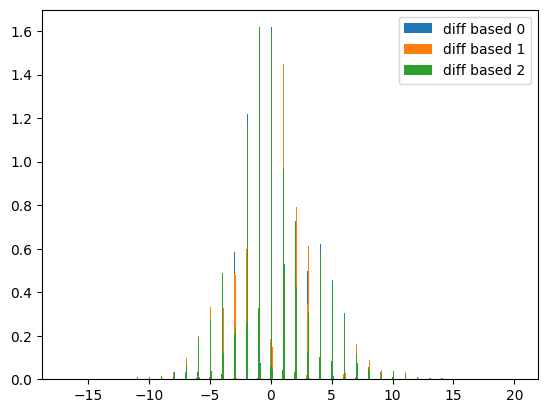

In [6]:
import matplotlib.pyplot as plt
#plt.hist(test_err_distribution_orig["data"], bins=1000, label="original", density=True)
plt.hist(test_err_distribution0["data"], bins=1000, label="diff based 0", density=True)
plt.hist(test_err_distribution1["data"], bins=1000, label="diff based 1", density=True)
plt.hist(test_err_distribution2["data"], bins=1000, label="diff based 2", density=True)
plt.legend()


#print(test_err_distribution["data"])

In [9]:
# mae_age = np.mean(np.abs(test_err_distribution_orig["data"]))
# print(f"MAE (orig): {mae_age}")
mae_age = np.mean(np.abs(test_err_distribution2["data"]))
print(f"MAE : {mae_age}")

MAE : 2.4987630805137697


In [16]:
np.mean(np.abs((test_err_distribution0["data"] + test_err_distribution1["data"] + test_err_distribution2["data"])/3))

2.498693853239839

In [7]:
np.mean(np.abs(test_err_distribution["data"][(np.abs(test_err_distribution["data"]) > 3) & (np.abs(test_err_distribution["data"]) < 50)]))

4.926654935531201

In [8]:
np.mean(np.abs(test_err_distribution_orig["data"][(np.abs(test_err_distribution_orig["data"]) > 3) & (np.abs(test_err_distribution_orig["data"]) < 50)]))

5.0405760304955685